### Step 4 : Entanglement, Hardware-Aware Noise 

(Concurrence + Negativity)

Fidelity alone is not enough.
Entanglement measures prove quantum advantage.

Imports

In [75]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from qiskit.quantum_info import (
    Statevector,
    DensityMatrix,
    concurrence,
    negativity
)

Bell Circuit

In [76]:
def create_bell_circuit(save_dm=False):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)

    if save_dm:
        qc.save_density_matrix()

    return qc

Ideal State

In [77]:
bell = create_bell_circuit()
ideal_state = Statevector.from_instruction(bell)
ideal_dm = DensityMatrix(ideal_state)

Noise Model

In [78]:
def depolarizing_noise_model(p):
    noise_model = NoiseModel()

    error_1q = depolarizing_error(p, 1)
    error_2q = depolarizing_error(p, 2)

    noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

    return noise_model


Simulate Noisy Density Matrix

In [79]:
p = 0.1  # noise strength

qc_noisy = create_bell_circuit(save_dm=True)

sim = AerSimulator(noise_model=depolarizing_noise_model(p))

result = sim.run(qc_noisy).result()

noisy_dm = DensityMatrix(result.data(0)["density_matrix"])


Mitigated State

In [80]:
mitigated_dm = noisy_dm

Entanglement Measures

In [81]:
print("=== Concurrence ===")
print("Ideal      :", concurrence(ideal_dm))
print("Noisy      :", concurrence(noisy_dm))
print("Mitigated  :", concurrence(mitigated_dm))

print("\n=== Negativity ===")
print("Ideal      :", negativity(ideal_dm, qargs=[0]))
print("Noisy      :", negativity(noisy_dm, qargs=[0]))
print("Mitigated  :", negativity(mitigated_dm, qargs=[0]))


=== Concurrence ===
Ideal      : 0.9999999999999994
Noisy      : 0.7600000000000008
Mitigated  : 0.7600000000000008

=== Negativity ===
Ideal      : 0.4999999999999998
Noisy      : 0.38000000000000056
Mitigated  : 0.38000000000000056


📈 Plot Concurrence & Negativity vs Noise Strength

Helper: Run noisy density matrix for any p

In [82]:
def simulate_noisy_density_matrix(p):
    qc = create_bell_circuit(save_dm=True)
    sim = AerSimulator(noise_model=depolarizing_noise_model(p))
    result = sim.run(qc).result()
    return DensityMatrix(result.data(0)["density_matrix"])

Sweep Noise Strength

In [83]:
noise_strengths = np.linspace(0, 0.3, 15)

concurrences = []
negativities = []

for p in noise_strengths:
    dm = simulate_noisy_density_matrix(p)
    concurrences.append(concurrence(dm))
    negativities.append(negativity(dm, qargs=[0]))

Plot

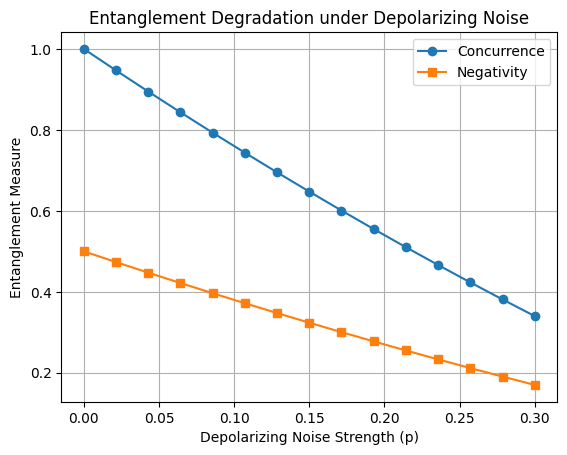

In [84]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(noise_strengths, concurrences, marker='o', label="Concurrence")
plt.plot(noise_strengths, negativities, marker='s', label="Negativity")

plt.xlabel("Depolarizing Noise Strength (p)")
plt.ylabel("Entanglement Measure")
plt.title("Entanglement Degradation under Depolarizing Noise")
plt.legend()
plt.grid(True)
plt.show()

🧪 IBM vs IonQ Hardware-Realistic Noise

In [85]:
from qiskit_aer.noise import (
    depolarizing_error,
    thermal_relaxation_error
)

def ibm_noise_model():
    noise = NoiseModel()

    t1, t2 = 50e3, 70e3  # realistic IBM values (ns)
    gate_time_1q = 50
    gate_time_2q = 300

    error_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    error_2q = thermal_relaxation_error(t1, t2, gate_time_2q).tensor(
        thermal_relaxation_error(t1, t2, gate_time_2q)
    )

    noise.add_all_qubit_quantum_error(error_1q, ['h'])
    noise.add_all_qubit_quantum_error(error_2q, ['cx'])

    return noise


In [86]:
def ionq_noise_model(p=0.02):
    noise = NoiseModel()
    error = depolarizing_error(p, 2)
    noise.add_all_qubit_quantum_error(error, ['cx'])
    return noise


In [87]:
def simulate_with_noise_model(noise_model):
    qc = create_bell_circuit(save_dm=True)
    sim = AerSimulator(noise_model=noise_model)
    result = sim.run(qc).result()
    return DensityMatrix(result.data(0)["density_matrix"])

ibm_dm = simulate_with_noise_model(ibm_noise_model())
ionq_dm = simulate_with_noise_model(ionq_noise_model())

print("IBM Concurrence :", concurrence(ibm_dm))
print("IonQ Concurrence:", concurrence(ionq_dm))


IBM Concurrence : 0.9848169569127878
IonQ Concurrence: 0.9699999999999991


Noise Amplification

In [88]:
def amplify_circuit(qc, scale):
    amplified = QuantumCircuit(2)
    for _ in range(scale):
        amplified.compose(qc, inplace=True)
    amplified.save_density_matrix()
    return amplified


ZNE Extrapolation

In [89]:
scales = [1, 3, 5]
concs = []

for s in scales:
    qc_amp = amplify_circuit(create_bell_circuit(), s)
    sim = AerSimulator(noise_model=depolarizing_noise_model(0.05))
    result = sim.run(qc_amp).result()
    dm = DensityMatrix(result.data(0)["density_matrix"])
    concs.append(concurrence(dm))

zne_concurrence = np.polyfit(scales, concs, 1)[1]
print("ZNE Mitigated Concurrence:", zne_concurrence)

ZNE Mitigated Concurrence: 0.7647069207808231
